In [ ]:
# First, install OpenFE and other required packages
!pip install openfe
!pip install numpy pandas scikit-learn lightgbm scipy xgboost tqdm pyarrow


In [ ]:
from openfe import OpenFE, transform
from sklearn.model_selection import train_test_split
import pandas as pd

btc_data = pd.read_csv('BTC_99.csv')

# Let's assume 'close' is the target variable you want to predict
label = btc_data['close']
data = btc_data.drop(['close'], axis=1)
display(data)



In [ ]:
# Convert 'date' to datetime and sort by it if needed
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

# Drop unnecessary columns like 'Unnamed: 0'
data = data.drop(['Unnamed: 0', 'date'], axis=1)

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)

# Initialize OpenFE
ofe = OpenFE()

# Generate new features
features = ofe.fit(data=train_x, label=train_y, n_jobs=14)  # Use all available cores for parallel computing

# Transform the train and test data according to generated features
train_x_transformed, test_x_transformed = transform(train_x, test_x, features, n_jobs=14)

# Now, 'train_x_transformed' and 'test_x_transformed' are ready for training and evaluation.


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')

# Fit the model on the transformed training data
xgb_model.fit(train_x_transformed, train_y)

# Make predictions on the test data
preds = xgb_model.predict(test_x_transformed)

# Calculate the mean squared error of the model
mse = mean_squared_error(test_y, preds)
print(f"Mean Squared Error: {mse}")

# If you want, you can also calculate other metrics and visualize feature importance


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation with 5 folds
cv_scores = cross_val_score(xgb_model, train_x_transformed, train_y, cv=5, scoring='neg_mean_squared_error')
cv_scores = np.sqrt(-cv_scores)  # Convert MSE to RMSE
print(f"Cross-Validation RMSE Scores: {cv_scores}")
print(f"Mean CV RMSE: {np.mean(cv_scores)}")

# Feature Importance
xgb.plot_importance(xgb_model)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv('BTC_99.csv')
close_prices = data['close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_close) * 0.8)
train, test = scaled_close[0:train_size, :], scaled_close[train_size:len(scaled_close), :]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Define look-back period
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), verbose=1)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions back to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_original = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_original = scaler.inverse_transform([testY])

# Calculate root mean squared error (RMSE) for evaluation
trainScore = np.sqrt(np.mean((trainPredict - trainY_original) ** 2))
print('Train RMSE:', trainScore)
testScore = np.sqrt(np.mean((testPredict - testY_original) ** 2))
print('Test RMSE:', testScore)


Epoch 1/100


2023-09-23 14:44:01.269763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:44:01.563116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/268 [..............................] - ETA: 5s - loss: 1.4214  

2023-09-23 14:44:01.866142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - ETA: 0s - loss: 0.6021

2023-09-23 14:44:06.207216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:44:06.250746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 7s 20ms/step - loss: 0.6021 - val_loss: 0.2999
Epoch 2/100
268/268 [==============================] - 5s 19ms/step - loss: 0.2941 - val_loss: 0.1543
Epoch 3/100
268/268 [==============================] - 5s 20ms/step - loss: 0.1826 - val_loss: 0.0739
Epoch 4/100
268/268 [==============================] - 5s 19ms/step - loss: 0.1231 - val_loss: 0.0336
Epoch 5/100
268/268 [==============================] - 5s 19ms/step - loss: 0.0951 - val_loss: 0.0157
Epoch 6/100
268/268 [==============================] - 5s 19ms/step - loss: 0.0835 - val_loss: 0.0092
Epoch 7/100
268/268 [==============================] - 5s 20ms/step - loss: 0.0802 - val_loss: 0.0070
Epoch 8/100
268/268 [==============================] - 5s 19ms/step - loss: 0.0773 - val_loss: 0.0065
Epoch 9/100
268/268 [==============================] - 6s 22ms/step - loss: 0.0775 - val_loss: 0.0059
Epoch 10/100
268/268 [==============================] - 5s 19ms/step - loss: 0.0764 - val_loss

2023-09-23 14:46:15.276895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:46:15.307134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


179/179 [==============================] - 1s 3ms/step


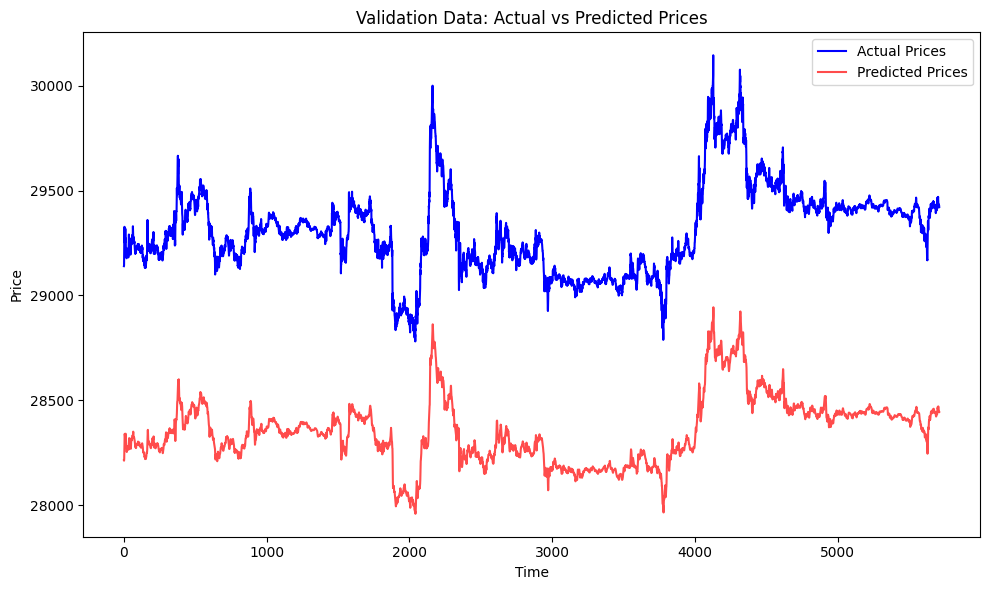

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv('BTC_99.csv')
dataset = data['close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train, test, and validation sets
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
train, val, test = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:,:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape data
look_back = 3
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network with Dropout and Regularization
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back), kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), bias_regularizer=L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[early_stop], verbose=1)

# Predict using the validation set
valPredict = model.predict(valX)

# Invert predictions to original scale
valPredict_original = scaler.inverse_transform(valPredict)
valY_original = scaler.inverse_transform([valY])

# Plotting actual vs predicted prices for validation set
plt.figure(figsize=(10, 6))
plt.plot(valY_original[0], label="Actual Prices", color="blue")
plt.plot(valPredict_original, label="Predicted Prices", color="red", alpha=0.7)
plt.title("Validation Data: Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


2023-09-23 14:49:41.989797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:49:42.080584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:49:42.186985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - ETA: 0s - loss: 0.5901

2023-09-23 14:49:46.248756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:49:46.289598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 6s 19ms/step - loss: 0.5901 - val_loss: 0.2976
Epoch 2/100
268/268 [==============================] - 5s 18ms/step - loss: 0.2921 - val_loss: 0.1534
Epoch 3/100
268/268 [==============================] - 5s 19ms/step - loss: 0.1828 - val_loss: 0.0734
Epoch 4/100
268/268 [==============================] - 5s 18ms/step - loss: 0.1229 - val_loss: 0.0333
Epoch 5/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0954 - val_loss: 0.0158
Epoch 6/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0835 - val_loss: 0.0089
Epoch 7/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0786 - val_loss: 0.0072
Epoch 8/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0787 - val_loss: 0.0063
Epoch 9/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0773 - val_loss: 0.0057
Epoch 10/100
268/268 [==============================] - 5s 18ms/step - loss: 0.0775 - val_loss

2023-09-23 14:52:28.412529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 14:52:28.447647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


894/894 [==============================] - 3s 3ms/step


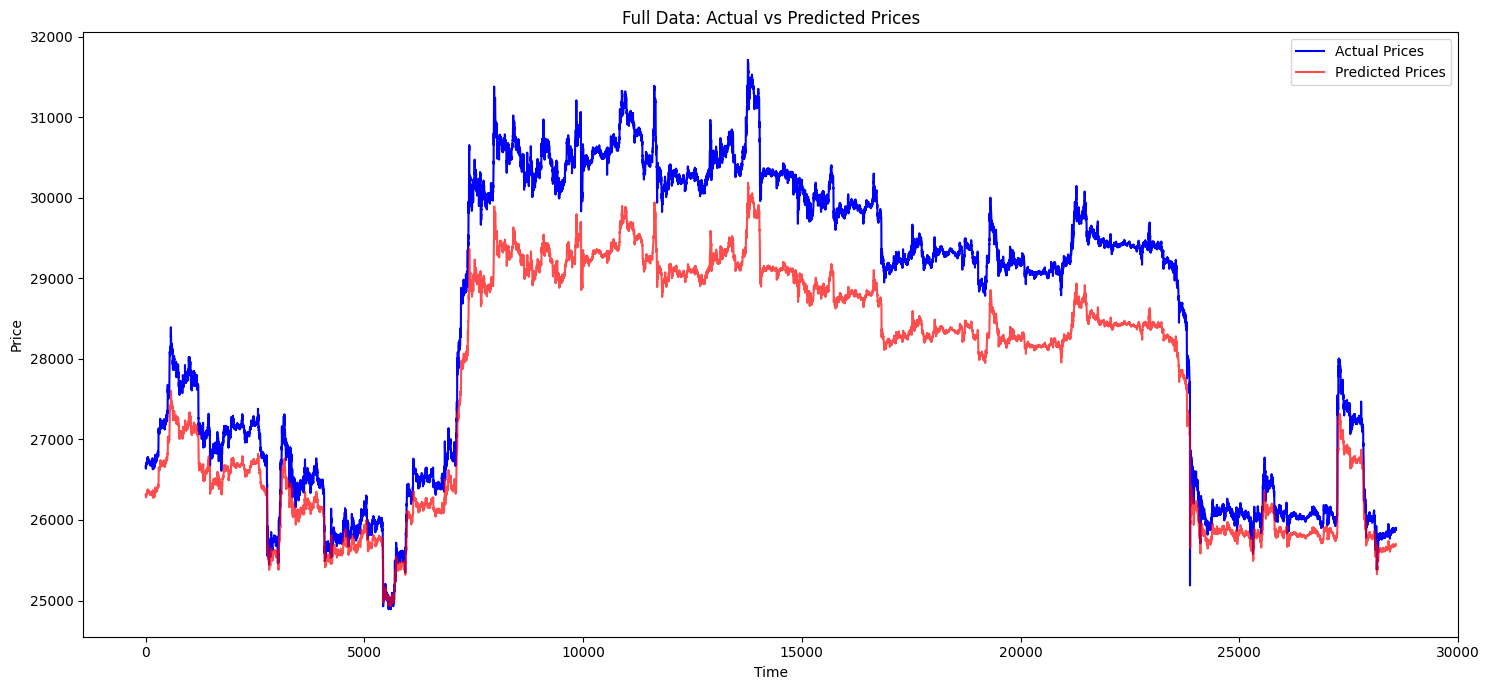

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv('BTC_99.csv')
dataset = data['close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train, test, and validation sets
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
train, val, test = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:,:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape data
look_back = 3
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM model with dropout and regularization
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back), kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), bias_regularizer=L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), callbacks=[early_stop], verbose=1)

# Predict using the entire dataset
full_dataX, _ = create_dataset(dataset, look_back)
full_dataX = np.reshape(full_dataX, (full_dataX.shape[0], 1, full_dataX.shape[1]))
fullPredict = model.predict(full_dataX)

# Invert predictions to original scale
fullPredict_original = scaler.inverse_transform(fullPredict)
dataset_original = scaler.inverse_transform(dataset)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dataset_original[look_back+1:], label="Actual Prices", color="blue")
plt.plot(fullPredict_original, label="Predicted Prices", color="red", alpha=0.7)
plt.title("Full Data: Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/l3/3nn8r4195jx8b6rzwks1y1pr0000gn/T/ipykernel_20509/3552086093.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('BTC_99.csv', date_parser=True)


Epoch 1/50


2023-09-23 15:10:25.933854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:10:26.022424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:10:26.104196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.0378

2023-09-23 15:10:27.975012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:10:28.007897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 3s 11ms/step - loss: 0.0378 - val_loss: 1.6783e-04
Epoch 2/50
215/215 [==============================] - 2s 11ms/step - loss: 5.0423e-04 - val_loss: 1.3814e-04
Epoch 3/50
215/215 [==============================] - 2s 10ms/step - loss: 1.3346e-04 - val_loss: 1.4144e-04
Epoch 4/50
215/215 [==============================] - 2s 11ms/step - loss: 1.2439e-04 - val_loss: 1.2135e-04
Epoch 5/50
215/215 [==============================] - 2s 11ms/step - loss: 1.1578e-04 - val_loss: 9.3757e-05
Epoch 6/50
215/215 [==============================] - 2s 11ms/step - loss: 1.0660e-04 - val_loss: 1.0549e-04
Epoch 7/50
215/215 [==============================] - 2s 10ms/step - loss: 9.6526e-05 - val_loss: 9.2057e-05
Epoch 8/50
215/215 [==============================] - 2s 10ms/step - loss: 8.6341e-05 - val_loss: 6.0330e-05
Epoch 9/50
215/215 [==============================] - 2s 10ms/step - loss: 7.5640e-05 - val_loss: 5.0953e-05
Epoch 10/50
215/215 [=============

2023-09-23 15:12:10.880064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:12:10.909401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 1s 3ms/step
Train RMSE: 2827.317804897698
Test RMSE: 709.0564853967924


ValueError: x and y must have same first dimension, but have shapes (9146,) and (9142, 1)

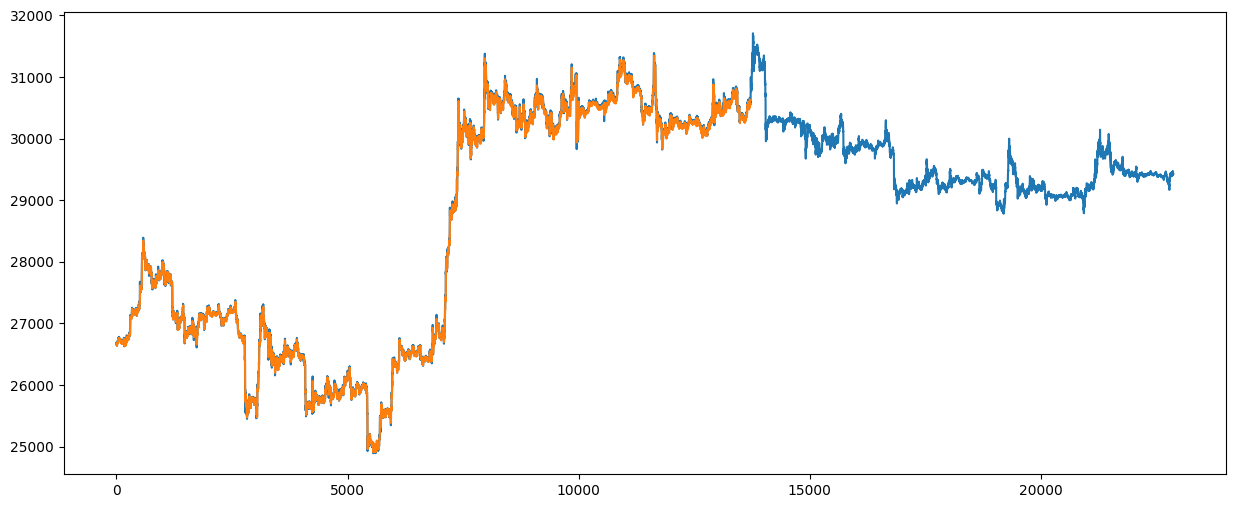

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('BTC_99.csv', date_parser=True)

# 1. Split the data into df1 (80%) and df2 (20%)
df1 = data.iloc[:int(0.8 * len(data))]
df2 = data.iloc[int(0.8 * len(data)):]

# 2. Normalize df1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df1_norm = scaler.fit_transform(df1['close'].values.reshape(-1, 1))

# 3. Split df1 into train (60%) and test (40%)
train_size = int(len(df1_norm) * 0.6)
train, test = df1_norm[0:train_size,:], df1_norm[train_size:,:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape data
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# 4. Train LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), verbose=1)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict - trainY_actual) ** 2))
print('Train RMSE:', trainScore)
testScore = np.sqrt(np.mean((testPredict - testY_actual) ** 2))
print('Test RMSE:', testScore)

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df1_norm), label='Actual')
plt.plot(np.arange(look_back, look_back + len(trainPredict)), trainPredict, label='Train Predict')
plt.plot(np.arange(look_back + len(trainPredict), len(df1_norm) - 1), testPredict, label='Test Predict')
plt.legend()
plt.show()


179/179 [==============================] - 1s 3ms/step


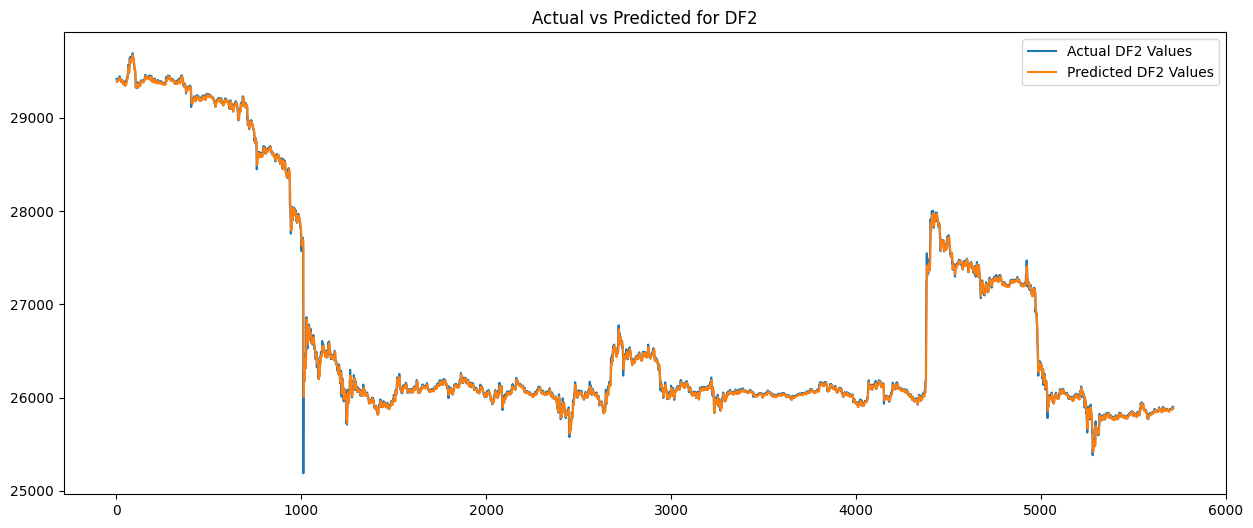

In [13]:
# 1. Normalize df2 using MinMaxScaler fitted on df1
df2_norm = scaler.transform(df2['close'].values.reshape(-1, 1))

# 2. Prepare data from df2
valX, _ = create_dataset(df2_norm, look_back)
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

# 3. Predict on df2
valPredict = model.predict(valX)

# Invert the prediction to original scale
valPredict = scaler.inverse_transform(valPredict)

# 4. Plot the actual vs predicted for df2
plt.figure(figsize=(15, 6))
plt.plot(df2['close'].values, label='Actual DF2 Values')
plt.plot(np.arange(look_back, len(df2) - 1), valPredict, label='Predicted DF2 Values')
plt.legend()
plt.title("Actual vs Predicted for DF2")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the data
data = pd.read_csv('BTC_99.csv', date_parser=True)
data = data.sort_values('date')

# Keep 80% for df1 and 20% for df2
split_point = int(0.8 * len(data))
df1 = data[:split_point].copy()
df2 = data[split_point:].copy()

# Use MinMaxScaler to scale data between 0 and 1
scaler = MinMaxScaler()
df1['close'] = scaler.fit_transform(df1['close'].values.reshape(-1, 1))

# Create function for processing data
def processData(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 7  # use 7 days to predict the 8th day
X, Y = processData(df1['close'], look_back)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, Y, epochs=50, batch_size=32)

# Predict the next time slot for 300 times
test_inputs = df1['close'].values[-look_back:].tolist()
predictions = []

for _ in range(300):
    test_seq = np.array(test_inputs[-look_back:])
    test_seq = test_seq.reshape(look_back, 1)
    test_seq = test_seq.reshape((1, look_back, 1))
    next_pred = model.predict(test_seq)
    predictions.append(scaler.inverse_transform(next_pred)[0][0])
    test_inputs.append(next_pred[0][0])

print(predictions)


Epoch 1/50


2023-09-23 15:25:05.732528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:25:05.885539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:25:06.081293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:25:06.260277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/571 [..............................] - ETA: 21s - loss: 0.1991  

2023-09-23 15:25:06.458482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


571/571 [==============================] - ETA: 0s - loss: 0.0019

2023-09-23 15:25:18.011912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:25:18.069625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:25:18.110693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


571/571 [==============================] - 15s 23ms/step - loss: 0.0019 - val_loss: 1.1856e-04
Epoch 2/50
571/571 [==============================] - 12s 21ms/step - loss: 1.3122e-04 - val_loss: 3.9443e-05
Epoch 3/50
571/571 [==============================] - 12s 21ms/step - loss: 1.1334e-04 - val_loss: 3.8589e-05
Epoch 4/50
571/571 [==============================] - 12s 21ms/step - loss: 1.0247e-04 - val_loss: 4.7274e-05
Epoch 5/50
571/571 [==============================] - 12s 21ms/step - loss: 1.1068e-04 - val_loss: 5.3068e-05
Epoch 6/50
571/571 [==============================] - 12s 21ms/step - loss: 9.1602e-05 - val_loss: 6.5135e-05
Epoch 7/50
571/571 [==============================] - 12s 21ms/step - loss: 8.6082e-05 - val_loss: 2.6173e-05
Epoch 8/50
571/571 [==============================] - 12s 21ms/step - loss: 7.2854e-05 - val_loss: 2.0001e-04
Epoch 9/50
571/571 [==============================] - 12s 21ms/step - loss: 6.9010e-05 - val_loss: 5.7464e-05
Epoch 10/50
571/571 [====

2023-09-23 15:29:55.051969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-23 15:29:55.109588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 722ms/step


2023-09-23 15:29:55.389875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


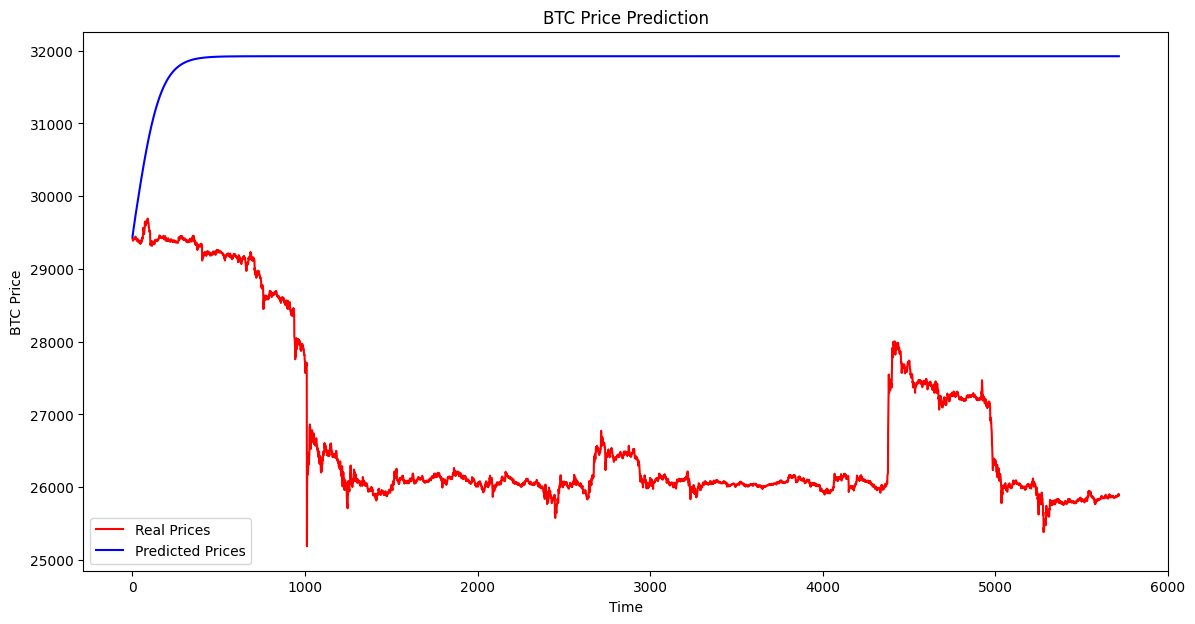

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv('BTC_99.csv')
data = data.sort_values('date')  # Adjusting column name to 'date'

# Split data into df1 (80%) and df2 (20%)
split_point = int(0.8 * len(data))
df1 = data.iloc[:split_point].copy()
df2 = data.iloc[split_point:].copy()

# Only use 'close' prices for predictions
train_set = df1['close'].values

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set.reshape(-1, 1))

# Create data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(train_set)):
    X_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Predict the next values for the length of df2
num_predictions = len(df2)
inputs = df1['close'].values[-60:].reshape(-1, 1)
inputs = scaler.transform(inputs)
predictions = []

for _ in range(num_predictions):
    X_test = np.array(inputs[-60:, 0]).reshape(1, 60, 1)
    predicted_price = model.predict(X_test)
    predictions.append(scaler.inverse_transform(predicted_price)[0, 0])
    inputs = np.vstack((inputs, predicted_price))

# Get the real prices from df2 for comparison
real_prices = df2['close'].values

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(real_prices, color='red', label='Real Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Load the data
data = pd.read_csv('BTC_99.csv')
data = data.sort_values('date')
data.set_index('date', inplace=True)

# Create df1 and df2
split_point = int(0.8 * len(data))
df1 = data[:split_point]
df2 = data[split_point:]

# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['close'].values.reshape(-1, 1))

# Create train and test datasets from df1
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:]

# Create a dataset function
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape to [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get real values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)


Epoch 1/50


2023-09-23 15:41:44.975385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 5s 16ms/step - loss: 0.0017
Epoch 2/50
286/286 [==============================] - 4s 14ms/step - loss: 3.3873e-05
Epoch 3/50
286/286 [==============================] - 4s 14ms/step - loss: 3.4030e-05
Epoch 4/50
286/286 [==============================] - 4s 14ms/step - loss: 3.3542e-05
Epoch 5/50
286/286 [==============================] - 4s 14ms/step - loss: 3.3820e-05
Epoch 6/50
286/286 [==============================] - 4s 14ms/step - loss: 3.3026e-05
Epoch 7/50
286/286 [==============================] - 4s 14ms/step - loss: 3.2864e-05
Epoch 8/50
286/286 [==============================] - 4s 14ms/step - loss: 3.4652e-05
Epoch 9/50
286/286 [==============================] - 4s 14ms/step - loss: 3.2578e-05
Epoch 10/50
286/286 [==============================] - 4s 14ms/step - loss: 3.4070e-05
Epoch 11/50
286/286 [==============================] - 4s 14ms/step - loss: 3.4046e-05
Epoch 12/50
286/286 [==============================] - 4s 14ms/step

2023-09-23 15:45:16.004207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


143/143 [==============================] - 1s 5ms/step
Train RMSE: 34.61115119197465
Test RMSE: 25.806070333812592


ValueError: x and y must have same first dimension, but have shapes (22864,) and (18291, 1)

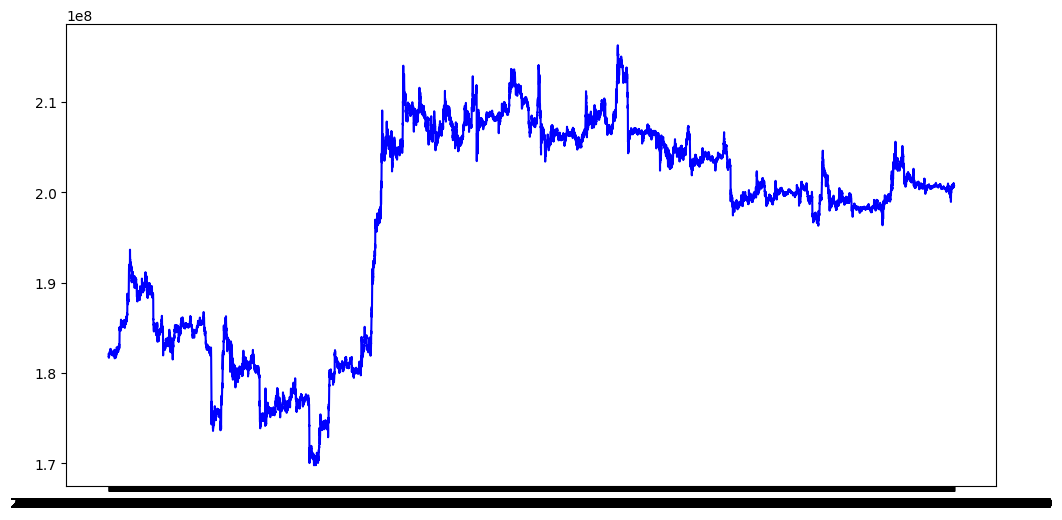

In [21]:
import matplotlib.pyplot as plt

# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df1.index[look_back:], scaler.inverse_transform(df1['close'][look_back:].values.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(df1.index[look_back:], train_predict, label='Train Predictions', color='orange')
plt.plot(df2.index, scaler.inverse_transform(df2['close'].values.reshape(-1, 1)), label='Actual Test Prices', color='green')
plt.plot(df2.index, test_predict, label='Test Predictions', color='red')

plt.title('Bitcoin Price Prediction using RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 4))
plt.bar(['Train', 'Test'], [train_rmse, test_rmse], color=['blue', 'red'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE Value')
plt.show()
